<a href="https://colab.research.google.com/github/MIARD/SMC/blob/main/SMC_ML_APP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: import python required library for a data analysis
# import time

# import matplotlib.pyplot as plt
# import seaborn as sns
# import plotly.express as px
# import plotly.graph_objects as go

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
# from sklearn.feature_selection import RFE
# from sklearn.ensemble import VotingClassifier
# from sklearn.ensemble import StackingClassifier
# from sklearn.pipeline import Pipeline
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import LabelEncoder

In [1]:
import joblib
import os
import pandas as pd
import numpy as np
from tabulate import tabulate
from datetime import datetime

In [2]:
# df = pd.read_excel('SSL_T.xlsx')
# df = pd.read_excel('SSL_T_MR.xlsx')
# df = pd.read_excel('SSL_M.xlsx')

# df = pd.read_excel('Train.xlsx')
# df = pd.read_excel('Test.xlsx')
# df = pd.read_excel('Train_Test.xlsx')

pd.set_option('display.max_rows', None)

##Overall Ratio Functions

In [ ]:
def calculate_prior_streaks(df):
    cl_list = [3]  # First trade starts with CL = 3
    cw_list = [0]  # First trade starts with CW = 0

    for i in range(1, len(df)):
        prev_result = df.loc[i - 1, 'Result']
        prev_cl = cl_list[-1]
        prev_cw = cw_list[-1]
        if prev_result == 'W':
            cw = prev_cw + 1
            cl = 0
        elif prev_result == 'L':
            cl = prev_cl + 1
            cw = 0
        else:
            cl = prev_cl
            cw = prev_cw

        cl_list.append(cl)
        cw_list.append(cw)

    df['CL'] = cl_list
    df['CW'] = cw_list
    return df

In [100]:
def select_rows_by_index(df, start_index, end_index):
  if not isinstance(df, pd.DataFrame):
    raise TypeError("Input must be a pandas DataFrame.")
  if not isinstance(start_index, int) or not isinstance(end_index, int):
    raise TypeError("Start and end indices must be integers.")
  if start_index < 0 or end_index < 0:
    raise ValueError("Start and end indices must be non-negative.")
  if start_index > end_index:
    raise ValueError("Start index cannot be greater than end index.")
  if start_index >= len(df):
    return pd.DataFrame(columns=df.columns) # Return empty DataFrame if start_index is out of bounds

  # Ensure the end_index does not exceed the DataFrame length
  actual_end_index = min(end_index, len(df) - 1)

  return df.iloc[start_index : actual_end_index + 1].copy()

In [97]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
def evaluate_models_on_test_data(X_test, y_test_binary, y_test_multi, models, model_names, model_keys, label_encoder, model_type):
    results = []
    for i, name in enumerate(model_names):
        model = models[i]

        # Binary Prediction and Accuracy
        y_pred_binary = model.predict(X_test)
        accuracy_binary = accuracy_score(y_test_binary, y_pred_binary)

        # Multi-class Prediction and Accuracy
        y_pred_multi = model.predict(X_test)
        accuracy_multi = accuracy_score(y_test_multi, y_pred_multi)

        results.append({
            'Model': name,
            'Binary Accuracy': accuracy_binary,
            'Multi-Class Accuracy': accuracy_multi,
            'Binary Predictions': y_pred_binary,
            'Multi-Class Predictions': y_pred_multi
        })
    return results

In [134]:
def calculate_metrics(group_df):
    total_trades = len(group_df)
    if total_trades == 0:
        return 0, 0, 0.0  # Trade Count, Profit/Loss, Win Rate

    total_pl = group_df['Profit/Loss'].sum()
    total_wins = (group_df['Profit/Loss'] > 0).sum()
    win_rate = total_wins / total_trades

    return total_trades, total_pl, win_rate

def overall_stats(df, features_filtered, models_data):
    overall_stats_df = pd.DataFrame()


    # Ensure required columns for filtering exist in the original df
    if 'Profit/Loss' not in df.columns:
        df['Profit/Loss'] = df['Profit'] - df['Loss'] - df['Fee']
    if 'Trade Duration (hours)' not in df.columns:
        df['Trade Duration (hours)'] = (df['exitDateTime'] - df['startDateTime']).dt.total_seconds() / 3600


    for i, model_data in enumerate(models_data):
        pred_result = model_data['Binary Predictions']
        df_filtered = df.copy()
        df_filtered['Predicted_Result'] = pred_result
        df_took_trade = df_filtered[df_filtered['Predicted_Result'] == 1]
        # print(df_took_trade.head( ))
        # 3. Overall statistic for filtered data frame
        if not df_took_trade.empty:
            total_trades = len(df_took_trade)
            total_wins = (df_took_trade['Profit/Loss'] > 0).sum()
            win_rate = total_wins / total_trades
            total_profit = df_took_trade['Profit'].sum()
            total_loss = df_took_trade['Loss'].sum()
            total_fee = df_took_trade['Fee'].sum()
            max_profit = df_took_trade['Profit/Loss'].max()
            max_loss = df_took_trade['Profit/Loss'].min()
            avg_profit = df_took_trade[df_took_trade['Profit/Loss'] > 0]['Profit/Loss'].mean() if (df_took_trade['Profit/Loss'] > 0).sum() > 0 else 0
            avg_loss = df_took_trade[df_took_trade['Profit/Loss'] < 0]['Profit/Loss'].mean() if (df_took_trade['Profit/Loss'] < 0).sum() > 0 else 0
            total_time = df_took_trade['Trade Duration (hours)'].sum()
            average_time = df_took_trade['Trade Duration (hours)'].mean()
            realized_pl = df_took_trade['Profit/Loss'].sum()
            avg_r_positive_pl = df_took_trade[df_took_trade['Profit/Loss'] > 0]['R'].mean()
            # Append the statistics as a new row to the overall_stats_df
            model_stats = {
                'Model': f"{model_data['Model']}({model_data['Binary Accuracy']:.2})",
                'Total Trades': total_trades,
                'Total Win Count': total_wins,
                'Total Loss Count': (df_took_trade['Profit/Loss'] < 0).sum(),
                'Total Profit': total_profit,
                'Total Loss': total_loss,
                'Total Fee': total_fee,
                'Win Rate (%)': round(win_rate * 100, 2),
                'Average R': round(avg_r_positive_pl, 2),
                'Max Profit': round(max_profit, 2),
                'Average Profit': round(avg_profit, 2),
                'Average Loss': round(avg_loss, 2),
                'Total Time (hours)': round(total_time, 2),
                'Average Time (hours)': round(average_time, 2),
                'Realized Profit/Loss': round(realized_pl, 2),
                'R': round(total_profit / (total_loss + total_fee), 2)
            }

            overall_stats_df = pd.concat([overall_stats_df, pd.DataFrame([model_stats])], ignore_index=True)

        else:
            print(f"No trades were 'taken' based on {model_names} predictions.")
            # Add a row of zeros for models with no predicted 'Win' trades
            model_stats = {
                'Model': model_names,
                'Total Trades': 0,
                'Total Win Count': 0,
                'Total Loss Count': 0,
                'Total Profit': 0,
                'Total Loss': 0,
                'Total Fee': 0,
                'Win Rate (%)': 0.0,
                'Max Profit': 0.0,
                'Average Profit': 0.0,
                'Average Loss': 0.0,
                'Total Time (hours)': 0.0,
                'Average Time (hours)': 0.0,
                'Realized Profit/Loss': 0.0
            }
            overall_stats_df = pd.concat([overall_stats_df, pd.DataFrame([model_stats])], ignore_index=True)
    return overall_stats_df

In [ ]:
def process_excel_and_predict(df, from_index, to_index, w_threshold = 1, s_print=False):
    # Check if the requested range is valid
    if from_index < 0 or to_index >= len(df) or from_index > to_index:
        print(f"Error: Invalid index range. Data has {len(df)} rows (0 to {len(df)-1}).")
        return None

    print(f"\n--- Processing rows from index {from_index} to {to_index} ---")

    summary_data = []

    # Process rows one by one
    for i in range(from_index, to_index + 1):
        row = df.loc[i]

        time_input = row['Start_Datetime'].strftime('%H:%M')
        date_input = row['Start_Datetime'].strftime('%m/%d/%Y')
        criteria_input = row['Criteria']  # Assuming 'Criteria' column exists
        cw_value = row['CW']
        cl_value = row['CL']
        actual_result = row['Result'] # Get the actual result

        print(f"\n--- Predicting for Row Index: {i} ---")
        print(f"Date: {date_input}, Time: {time_input}, Criteria: {criteria_input}, Prior CL: {cl_value}, Prior CW: {cw_value}")

        # Make predictions using the existing show_predictions function
        # Ensure precomputed_stats, training_feature_cols, models, and encoders are loaded globally or passed
        try:
            # Get predictions for regular models
            predictions_reg_bin, predictions_reg_multi = show_predictions(
                time_input,
                date_input,
                criteria_input,
                cw_value,
                cl_value,
                training_feature_cols,
                model_names,
                model_keys,
                precomputed_stats=precomputed_stats,
                label_encoder=label_encoder,
                b_models=regular_binary_models,
                m_models=regular_multi_models,
                b_acc=regular_accuracies['Binary Accuracy'],
                m_acc=regular_accuracies['Multi-Class (R Bucket) Accuracy'],
                s_print=s_print,
                w_threshold=w_threshold
            )

            # Get predictions for max R models
            predictions_max_r_bin, predictions_max_r_multi = show_predictions(
                time_input,
                date_input,
                criteria_input,
                cw_value,
                cl_value,
                training_feature_cols,
                model_names_max_r,
                model_keys,
                precomputed_stats=precomputed_stats,
                label_encoder=label_encoder,
                b_models=max_r_binary_models,
                m_models=max_r_multi_models,
                b_acc=max_r_accuracies['Binary Accuracy'],
                m_acc=max_r_accuracies['Multi-Class (R Bucket) Accuracy'],
                s_print=s_print,
                w_threshold=w_threshold,
                Max_R=True
            )
            old_predictions_reg_bin, old_predictions_reg_multi = show_predictions(
                time_input,
                date_input,
                criteria_input,
                cw_value,
                cl_value,
                old_training_feature_cols,
                model_names,
                model_keys,
                precomputed_stats=old_precomputed_stats,
                label_encoder=old_label_encoder,
                b_models=old_regular_binary_models,
                m_models=old_regular_multi_models,
                b_acc=old_regular_accuracies['Binary Accuracy'],
                m_acc=old_regular_accuracies['Multi-Class (R Bucket) Accuracy'],
                s_print=s_print,
                w_threshold=w_threshold,
            )

            if predictions_reg_bin is not None and predictions_reg_multi is not None and \
               predictions_max_r_bin is not None and predictions_max_r_multi is not None:

                row_summary = {
                    'Index': i+1,
                    'Date': date_input,
                    'Time': time_input,
                    'Criteria': criteria_input,
                    'CL': cl_value,
                    'CW': cw_value,
                    'Actual_R': actual_result
                }



                # Add combined binary prediction (Regular)
                predicted_win_reg_bin = predictions_reg_bin.count(1)
                trade_decision_reg_bin = "Win" if predicted_win_reg_bin >= w_threshold else "Loss"
                # Add combined multi-class prediction (Regular)
                predicted_win_reg_multi = len(predictions_reg_multi)-predictions_reg_multi.count(0)
                trade_decision_reg_multi = "Win" if predicted_win_reg_multi >= w_threshold else "Loss"
                # Add OLD combined prediction (Regular)
                predicted_win_old_bin = old_predictions_reg_bin.count(1)
                trade_decision_old_bin = "Win" if predicted_win_old_bin >= w_threshold else "Loss"


                row_summary['O-C-BD'] = trade_decision_old_bin
                row_summary['O-WC-B'] = predicted_win_old_bin
                row_summary['RC-BD'] = trade_decision_reg_bin
                row_summary['RWC-B'] = predicted_win_reg_bin



                row_summary['RC-MD'] = trade_decision_reg_multi
                row_summary['RWC-M'] = predicted_win_reg_multi

                row_summary['B_Pred'] = predictions_reg_bin
                row_summary['M_Pred'] = predictions_reg_multi

                row_summary['O_B_Pred'] = old_predictions_reg_bin
                row_summary['O_M_Pred'] = old_predictions_reg_multi

                row_summary['MR_B_Pred'] = predictions_max_r_bin
                row_summary['MR_M_Pred'] = predictions_max_r_multi

                # if trade_decision_reg_multi == "Win":
                #     row_summary['R_M_R'] = np.max(predictions_reg_multi)
                #     row_summary['R_A_R'] = np.mean([x for x in predictions_reg_multi if x > 0])
                # else:
                #     row_summary['R_M_R'] = 0
                #     row_summary['R_A_R'] = 0

                #ADD old Biinary


                # Add combined multi-class prediction (Max R)
                predicted_win_max_r_multi = len(predictions_max_r_multi)-predictions_max_r_multi.count(0)
                trade_decision_max_r_multi = "Win" if predicted_win_max_r_multi >= w_threshold else "Loss"
                row_summary['M-C-MD'] = trade_decision_max_r_multi
                row_summary['M-WC-M'] = predicted_win_max_r_multi
                # if trade_decision_max_r_multi == "Win":
                #     row_summary['MR_M_R'] = np.max(predictions_max_r_multi)
                #     row_summary['MR_A_R'] = np.mean([x for x in predictions_max_r_multi if x > 0])
                # else:
                #     row_summary['MR_M_R'] = 0
                    # row_summary['MR_A_R'] = 0


                summary_data.append(row_summary)

        except Exception as e:
             print(f"An error occurred during prediction for index {i}: {e}")
             # Append a row indicating an error if needed
             error_row = {'Index': i, 'Date': date_input, 'Time': time_input, 'Criteria': criteria_input,
                          'CL': cl_value, 'CW': cw_value, 'Actual_R': actual_result, 'Error': str(e)}
             summary_data.append(error_row)


    # Create DataFrame from the collected summary data
    summary_df = pd.DataFrame(summary_data)


    return summary_df

In [4]:
def show_model_result(model_name, accuracy, class_report):
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)

##Get Feature Data & Train Data From Input

In [ ]:
def get_feature_data(p_state, index, row):
    # Retrieve stats for individual features
    row_data = {}
    time_15min = row['15Min']
    trade_count_15m, pl_15m, win_rate_15m = precomputed_stats[('15Min', time_15min)]
    row_data['15Min_Trade Count'] = trade_count_15m
    row_data['15Min_Win Rate'] = win_rate_15m
    row_data['15Min_Profit/Loss'] = pl_15m

    hour = row['Hour']
    trade_count_hour, pl_hour, win_rate_hour = precomputed_stats[('Hour', hour)]
    row_data['Hour_Trade Count'] = trade_count_hour
    row_data['Hour_Win Rate'] = win_rate_hour
    row_data['Hour_Profit/Loss'] = pl_hour
    weekday = row['Start_Weekday']
    trade_count_weekday, pl_weekday, win_rate_weekday = precomputed_stats[('Weekday', weekday)]
    row_data['Weekday_Trade Count'] = trade_count_weekday
    row_data['Weekday_Win Rate'] = win_rate_weekday
    row_data['Weekday_Profit/Loss'] = pl_weekday

    month = row['Month']
    trade_count_month, pl_month, win_rate_month = precomputed_stats[('Month', month)]
    row_data['Month_Trade Count'] = trade_count_month
    row_data['Month_Win Rate'] = win_rate_month
    row_data['Month_Profit/Loss'] = pl_month

    criteria = row['Criteria']
    trade_count_criteria, pl_criteria, win_rate_criteria = precomputed_stats[('Criteria', criteria)]
    row_data['Criteria_Trade Count'] = trade_count_criteria
    row_data['Criteria_Win Rate'] = win_rate_criteria
    row_data['Criteria_Profit/Loss'] = pl_criteria

    # Add features for Day of Month and Week of Month
    day_of_month = row['Day_of_Month']
    trade_count_day, pl_day, win_rate_day = precomputed_stats[('Day_of_Month', day_of_month)]
    row_data['Day_of_Month_Trade Count'] = trade_count_day
    row_data['Day_of_Month_Win Rate'] = win_rate_day
    row_data['Day_of_Month_Profit/Loss'] = pl_day

    week_of_month = row['Week_of_Month']
    trade_count_week, pl_week, win_rate_week = precomputed_stats[('Week_of_Month', week_of_month)]
    row_data['Week_of_Month_Trade Count'] = trade_count_week
    row_data['Week_of_Month_Win Rate'] = win_rate_week
    row_data['Week_of_Month_Profit/Loss'] = pl_week

    # Retrieve stats for combined features
    trade_count_weekday_15m, pl_weekday_15m, win_rate_weekday_15m = precomputed_stats[('Weekday_15Min', weekday, time_15min)]
    row_data['Weekday_15Min_Trade Count'] = trade_count_weekday_15m
    row_data['Weekday_15Min_Win Rate'] = win_rate_weekday_15m
    row_data['Weekday_15Min_Profit/Loss'] = pl_weekday_15m

    trade_count_weekday_hour, pl_weekday_hour, win_rate_weekday_hour = precomputed_stats[('Weekday_Hour', weekday, hour)]
    row_data['Weekday_Hour_Trade Count'] = trade_count_weekday_hour
    row_data['Weekday_Hour_Win Rate'] = win_rate_weekday_hour
    row_data['Weekday_Hour_Profit/Loss'] = pl_weekday_hour

    trade_count_weekday_month, pl_weekday_month, win_rate_weekday_month = precomputed_stats[('Weekday_Month', weekday, month)]
    row_data['Weekday_Month_Trade Count'] = trade_count_weekday_month
    row_data['Weekday_Month_Win Rate'] = win_rate_weekday_month
    row_data['Weekday_Month_Profit/Loss'] = pl_weekday_month

    trade_count_criteria_15m, pl_criteria_15m, win_rate_criteria_15m = precomputed_stats[('Criteria_15Min', criteria, time_15min)]
    row_data['Criteria_15Min_Trade Count'] = trade_count_criteria_15m
    row_data['Criteria_15Min_Win Rate'] = win_rate_criteria_15m
    row_data['Criteria_15Min_Profit/Loss'] = pl_criteria_15m

    trade_count_criteria_hour, pl_criteria_hour, win_rate_criteria_hour = precomputed_stats[('Criteria_Hour', criteria, hour)]
    row_data['Criteria_Hour_Trade Count'] = trade_count_criteria_hour
    row_data['Criteria_Hour_Win Rate'] = win_rate_criteria_hour
    row_data['Criteria_Hour_Profit/Loss'] = pl_criteria_hour

    trade_count_criteria_weekday, pl_criteria_weekday, win_rate_criteria_weekday = precomputed_stats[('Criteria_Weekday', criteria, weekday)]
    row_data['Criteria_Weekday_Trade Count'] = trade_count_criteria_weekday
    row_data['Criteria_Weekday_Win Rate'] = win_rate_criteria_weekday
    row_data['Criteria_Weekday_Profit/Loss'] = pl_criteria_weekday

    trade_count_criteria_month, pl_criteria_month, win_rate_criteria_month = precomputed_stats[('Criteria_Month', criteria, month)]
    row_data['Criteria_Month_Trade Count'] = trade_count_criteria_month
    row_data['Criteria_Month_Win Rate'] = win_rate_criteria_month
    row_data['Criteria_Month_Profit/Loss'] = pl_criteria_month

    trade_count_hour_month, pl_hour_month, win_rate_hour_month = precomputed_stats[('Hour_Month', hour, month)]
    row_data['Hour_Month_Trade Count'] = trade_count_hour_month
    row_data['Hour_Month_Win Rate'] = win_rate_hour_month
    row_data['Hour_Month_Profit/Loss'] = pl_hour_month

    trade_count_15min_month, pl_15min_month, win_rate_15min_month = precomputed_stats[('15Min_Month', time_15min, month)]
    row_data['15Min_Month_Trade Count'] = trade_count_15min_month
    row_data['15Min_Month_Win Rate'] = win_rate_15min_month
    row_data['15Min_Month_Profit/Loss'] = pl_15min_month

    # Add combined features for Day of Month and Week of Month
    trade_count_weekday_day, pl_weekday_day, win_rate_weekday_day = precomputed_stats[('Weekday_Day', weekday, day_of_month)]
    row_data['Weekday_Day_Trade Count'] = trade_count_weekday_day
    row_data['Weekday_Day_Win Rate'] = win_rate_weekday_day
    row_data['Weekday_Day_Profit/Loss'] = pl_weekday_day

    trade_count_weekday_week, pl_weekday_week, win_rate_weekday_week = precomputed_stats[('Weekday_Week', weekday, week_of_month)]
    row_data['Weekday_Week_Trade Count'] = trade_count_weekday_week
    row_data['Weekday_Week_Win Rate'] = win_rate_weekday_week
    row_data['Weekday_Week_Profit/Loss'] = pl_weekday_week

    trade_count_criteria_day, pl_criteria_day, win_rate_criteria_day = precomputed_stats[('Criteria_Day', criteria, day_of_month)]
    row_data['Criteria_Day_Trade Count'] = trade_count_criteria_day
    row_data['Criteria_Day_Win Rate'] = win_rate_criteria_day
    row_data['Criteria_Day_Profit/Loss'] = pl_criteria_day

    trade_count_criteria_week, pl_criteria_week, win_rate_criteria_week = precomputed_stats[('Criteria_Week', criteria, week_of_month)]
    row_data['Criteria_Week_Trade Count'] = trade_count_criteria_week
    row_data['Criteria_Week_Win Rate'] = win_rate_criteria_week
    row_data['Criteria_Week_Profit/Loss'] = pl_criteria_week

    trade_count_hour_day, pl_hour_day, win_rate_hour_day = precomputed_stats[('Hour_Day', hour, day_of_month)]
    row_data['Hour_Day_Trade Count'] = trade_count_hour_day
    row_data['Hour_Day_Win Rate'] = win_rate_hour_day
    row_data['Hour_Day_Profit/Loss'] = pl_hour_day

    trade_count_hour_week, pl_hour_week, win_rate_hour_week = precomputed_stats[('Hour_Week', hour, week_of_month)]
    row_data['Hour_Week_Trade Count'] = trade_count_hour_week
    row_data['Hour_Week_Win Rate'] = win_rate_hour_week
    row_data['Hour_Week_Profit/Loss'] = pl_hour_week

    trade_count_15min_day, pl_15min_day, win_rate_15min_day = precomputed_stats[('15Min_Day', time_15min, day_of_month)]
    row_data['15Min_Day_Trade Count'] = trade_count_15min_day
    row_data['15Min_Day_Win Rate'] = win_rate_15min_day
    row_data['15Min_Day_Profit/Loss'] = pl_15min_day

    trade_count_15min_week, pl_15min_week, win_rate_15min_week = precomputed_stats[('15Min_Week', time_15min, week_of_month)]
    row_data['15Min_Week_Trade Count'] = trade_count_15min_week
    row_data['15Min_Week_Win Rate'] = win_rate_15min_week
    row_data['15Min_Week_Profit/Loss'] = pl_15min_week

    trade_count_month_day, pl_month_day, win_rate_month_day = precomputed_stats[('Month_Day', month, day_of_month)]
    row_data['Month_Day_Trade Count'] = trade_count_month_day
    row_data['Month_Day_Win Rate'] = win_rate_month_day
    row_data['Month_Day_Profit/Loss'] = pl_month_day

    trade_count_month_week, pl_month_week, win_rate_month_week = precomputed_stats[('Month_Week', month, week_of_month)]
    row_data['Month_Week_Trade Count'] = trade_count_month_week
    row_data['Month_Week_Win Rate'] = win_rate_month_week
    row_data['Month_Week_Profit/Loss'] = pl_month_week

    trade_count_day_week, pl_day_week, win_rate_day_week = precomputed_stats[('Day_Week', day_of_month, week_of_month)]
    row_data['Day_Week_Trade Count'] = trade_count_day_week
    row_data['Day_Week_Win Rate'] = win_rate_day_week
    row_data['Day_Week_Profit/Loss'] = pl_day_week

    return row_data

In [76]:
def get_train_data_for_input(precomputed_stats, time_input, date_input, criteria_input, training_feature_cols=[]):

    # Convert inputs
    try:
        input_time = datetime.strptime(time_input, '%H:%M').time()
    except ValueError:
        print("Invalid time format. Use HH:MM.")
        return pd.DataFrame()

    try:
        input_date = datetime.strptime(date_input, '%m/%d/%Y')
    except ValueError:
        print("Invalid date format. Use M/D/YYYY.")
        return pd.DataFrame()

    row_data = {}
    input_datetime = datetime.combine(input_date, input_time)
    time_15min = input_datetime.strftime('%H:%M')
    hour = input_datetime.hour
    weekday = input_datetime.strftime('%A')
    month = input_datetime.strftime('%B')
    criteria = criteria_input
    day_of_month = input_datetime.day
    week_of_month = (input_datetime.day - 1) // 7 + 1

    # Retrieve stats from precomputed_stats dictionary
    try:
        row = {'15Min': time_15min, 'Hour': hour, 'Start_Weekday': weekday, 'Month': month, 'Criteria': criteria, 'Day_of_Month':day_of_month, 'Week_of_Month':week_of_month}
        row_data = get_feature_data(precomputed_stats, 0, row)

    except KeyError as e:
        print(f"Error: Missing precomputed statistic for key {e}. Ensure create_precomputed_stats covers all combinations you need.")
        return pd.DataFrame()


    # Create DataFrame from the calculated row_data
    input_features_df = pd.DataFrame([row_data])
    # Reindex the input_features_df to match the training columns, filling missing with 0
    input_features_df = input_features_df.reindex(columns=training_feature_cols, fill_value=0)

    # Convert all columns to the same data type as the training features (assuming int from previous steps)
    for col in input_features_df.columns:
        try:
             input_features_df[col] = pd.to_numeric(input_features_df[col], errors='coerce')
             input_features_df[col] = input_features_df[col].fillna(0).astype(int)
        except ValueError:
            print(f"Warning: Could not convert input column '{col}' to integer.")


    return input_features_df

# Example usage (assuming X_train is defined from the previous code):
# Get the column names from your training features DataFrame

# Call the optimized function
# input_data = get_train_data_for_input_optimized(precomputed_stats, '09:30', '01/8/2023', 'ELC', training_feature_cols)
# print(input_data)


##Show Prediciton

In [30]:
# --- Prediction using the trained model ---
def predict_trade_result(model, input_features_df):

    if input_features_df.empty:
        print("Cannot predict: Invalid input features.")
        return None, None

    # Make prediction
    predicted_class = model.predict(input_features_df)[0]
    if predicted_class == 0:
        predicted_proba = model.predict_proba(input_features_df)
    else:
        predicted_proba = model.predict_proba(input_features_df)

    return predicted_class, predicted_proba

In [7]:
  # pip install tabulate if needed

def show_predictions(time_input, date_input, criteria_input, CW, CL, training_feature_cols,model_names, model_keys, precomputed_stats=None,label_encoder=None, b_models=None, m_models=None, b_acc=None, m_acc=None, Max_R=False, s_print=True, w_threshold=1):
    mr = "_max_r" if Max_R else ""
    # Initialize models and their keys
    binary_models = b_models if b_models is not None else [globals()[f"{k}_model{mr}"] for k in model_keys]
    binary_accuracies = b_acc if b_acc is not None else [globals()[f"{k}_accuracy{mr}"] for k in model_keys]

    multiclass_models = m_models if m_models is not None else [globals()[f"{k}_model_m{mr}"] for k in model_keys]
    multiclass_accuracies = m_acc if m_acc is not None else [globals()[f"{k}_accuracy_m{mr}"] for k in model_keys]
    input_features = get_train_data_for_input(precomputed_stats, time_input, date_input, criteria_input, training_feature_cols)
    input_features['CL'] = [CL]
    input_features['CW'] = [CW]
    predictions = []
    predictions_multi = []
    if not input_features.empty:
        table_data = []

        for i, name in enumerate(model_names):
            # Predict binary
            pred_bin, prob_bin = predict_trade_result(binary_models[i], input_features)
            label_bin = 'Win' if pred_bin == 1 else 'Loss'
            acc_bin = f"{binary_accuracies[i]:.2f}"
            bin_str = f"{label_bin} ({np.max(prob_bin):.2f}), Acc: {acc_bin}"

            # Predict multiclass
            pred_multi, prob_multi = predict_trade_result(multiclass_models[i], input_features)
            acc_multi = f"{multiclass_accuracies[i]:.2f}"
            multi_str = f"Class {label_encoder.inverse_transform([pred_multi])[0]} ({np.max(prob_multi):.2f}), Acc: {acc_multi}"
            table_data.append([name, bin_str, multi_str])
            predictions.append(pred_bin)
            predictions_multi.append(pred_multi)
        predicted_win = predictions.count(1)
        predicted_loss = predictions.count(0)
        predicted_win_multi = len(predictions)-predictions_multi.count(0)
        predicted_loss_multi = predictions_multi.count(0)
        trade_decision = "Win" if predicted_win > w_threshold else "Loss"
        trade_decision_multi = "Win" if predicted_win_multi >= w_threshold else "Loss"
        max_r = "" if trade_decision_multi == "Loss" else "- Max R: "+str(np.max(predictions_multi))
        avg_r = "" if trade_decision_multi == "Loss" else "- Average R:"+str(np.mean([x for x in predictions_multi if x>0]))
        # Display table
        if s_print:
            print(f"\n--- 📊 Combined Model Predictions for {date_input} {time_input} ({criteria_input}) -{mr} ---\n")
            print(f"Overall decision: ---- Binary: ** {trade_decision} **  Multi: ** {trade_decision_multi}** ---- {max_r} {avg_r}")
            print(f"Binary Models: Win Predicted **{predicted_win} time **    Multi Models: Win Predicted **{predicted_win_multi}**")
            print(tabulate(table_data, headers=["Model", "📘 Binary (Win/Loss)", "📗 Multi-Class (R Bucket)"], tablefmt="fancy_grid"))
        return predictions, predictions_multi

    else:
        print("❌ Prediction could not be made due to invalid inputs or data.")


#Read Require Data

##Read Models

##Read From Drive

In [ ]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# # prompt: remove SMC directory from my files
# %cd /content/
# !rm -rf SMC/

In [ ]:
# Copy SMC folder from Drive to current working directory (optional)
# !cp -r /content/drive/MyDrive/SMC /content/
# %cd /content/SMC

# !ls

##Read From Git

In [8]:
# Clone the GitHub repository
!git clone https://github.com/MIARD/SMC.git

# Move into the cloned directory
%cd SMC

# List files to confirm
!ls

Cloning into 'SMC'...
remote: Enumerating objects: 175, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 175 (delta 20), reused 28 (delta 13), pack-reused 134 (from 1)
Receiving objects: 100% (175/175), 43.68 MiB | 20.86 MiB/s, done.
Resolving deltas: 100% (114/114), done.
/content/SMC
cmd_arg.txt    README.md		SMC_ML_APP.ipynb  SSL_T_MR.xlsx
Get_EMA.ipynb  saved_models		smc_ml_app.py	  SSL_T.xlsx
get-pip.py     SMC_Data_Analysis.ipynb	SMC_ML.ipynb
old_models     smc_data_analysis.py	smc_ml.py


##Read info

In [9]:
# prompt: read both accuracies from save xlxs and show their tables

# Read the saved accuracy dataframes
def read_accuracy_dataframes(file_dir):
    try:
      precomputed_stats = joblib.load(f'{file_dir}/precomputed_stats.pkl')
      training_feature_cols = joblib.load(f'{file_dir}/training_feature_cols.pkl')
      regular_accuracies = pd.read_excel(f'{file_dir}/regular_model_accuracies.xlsx')
      max_r_accuracies = pd.read_excel(f'{file_dir}/max_r_model_accuracies.xlsx')

      print("\n--- Regular Model Accuracies ---")
      print(tabulate(regular_accuracies, headers='keys', tablefmt='psql'))

      print("\n--- Max R Model Accuracies ---")
      print(tabulate(max_r_accuracies, headers='keys', tablefmt='psql'))

      return precomputed_stats, training_feature_cols, regular_accuracies, max_r_accuracies

    except FileNotFoundError:
      print("Accuracy files not found. Please run the model training section first.")
    except Exception as e:
      print(f"An error occurred while reading the accuracy files: {e}")

In [10]:
accuracies_dir = 'saved_models/accuracies'
precomputed_stats, training_feature_cols, regular_accuracies, max_r_accuracies = read_accuracy_dataframes(accuracies_dir)


--- Regular Model Accuracies ---
+----+---------------------+-------------------+-----------------------------------+
|    | Model               |   Binary Accuracy |   Multi-Class (R Bucket) Accuracy |
|----+---------------------+-------------------+-----------------------------------|
|  0 | RandomForest        |          0.964286 |                          0.857143 |
|  1 | XGBoost             |          0.967532 |                          0.873377 |
|  2 | Logistic Regression |          0.970779 |                          0.86039  |
|  3 | Voting Classifier   |          0.974026 |                          0.876623 |
|  4 | Stacking Classifier |          0.967532 |                          0.876623 |
+----+---------------------+-------------------+-----------------------------------+

--- Max R Model Accuracies ---
+----+---------------------------+-------------------+-----------------------------------+
|    | Model                     |   Binary Accuracy |   Multi-Class (R Bucket

In [11]:
old_accuracies_dir = 'old_models/accuracies'
print('OLD Model:')
old_precomputed_stats, old_training_feature_cols, old_regular_accuracies, old_max_r_accuracies = read_accuracy_dataframes(old_accuracies_dir)

OLD Model:

--- Regular Model Accuracies ---
+----+---------------------+-------------------+-----------------------------------+
|    | Model               |   Binary Accuracy |   Multi-Class (R Bucket) Accuracy |
|----+---------------------+-------------------+-----------------------------------|
|  0 | RandomForest        |          0.960912 |                          0.86645  |
|  1 | XGBoost             |          0.960912 |                          0.885993 |
|  2 | Logistic Regression |          0.973941 |                          0.859935 |
|  3 | Voting Classifier   |          0.967427 |                          0.882736 |
|  4 | Stacking Classifier |          0.964169 |                          0.856678 |
+----+---------------------+-------------------+-----------------------------------+

--- Max R Model Accuracies ---
+----+---------------------------+-------------------+-----------------------------------+
|    | Model                     |   Binary Accuracy |   Multi-Clas

##Loading Models

In [12]:
# prompt: read all 20 models separately  regular binary, regular multi, max r binary, max r multi, . so that i can pass binary model and multi models list to function easily

# Define a directory to save the models
def read_models(model_dir):

    # Define lists to store the loaded models
    regular_binary_models = []
    regular_multi_models = []
    max_r_binary_models = []
    max_r_multi_models = []

    # List of model base names (keys used in filenames)
    model_keys = ['RF', 'XVG', 'LR', 'VC', 'S']

    # Load regular binary models
    print("Loading regular binary models...")
    for key in model_keys:
        filename = os.path.join(model_dir, f'{key}_model.pkl')
        try:
            model = joblib.load(filename)
            regular_binary_models.append(model)
            print(f"Loaded {key}_model")
        except FileNotFoundError:
            print(f"Error: {key}_model.pkl not found. Please run the saving section first.")
        except Exception as e:
            print(f"Error loading {key}_model: {e}")

    # Load regular multi-class models
    print("\nLoading regular multi-class models...")
    for key in model_keys:
        filename = os.path.join(model_dir, f'{key}_model_m.pkl')
        try:
            model = joblib.load(filename)
            regular_multi_models.append(model)
            print(f"Loaded {key}_model_m")
        except FileNotFoundError:
            print(f"Error: {key}_model_m.pkl not found. Please run the saving section first.")
        except Exception as e:
            print(f"Error loading {key}_model_m: {e}")

    # Load max R binary models
    print("\nLoading Max R binary models...")
    for key in model_keys:
        filename = os.path.join(model_dir, f'{key}_model_max_r.pkl')
        try:
            model = joblib.load(filename)
            max_r_binary_models.append(model)
            print(f"Loaded {key}_model_max_r")
        except FileNotFoundError:
            print(f"Error: {key}_model_max_r.pkl not found. Please run the saving section first.")
        except Exception as e:
            print(f"Error loading {key}_model_max_r: {e}")

    # Load max R multi-class models
    print("\nLoading Max R multi-class models...")
    for key in model_keys:
        filename = os.path.join(model_dir, f'{key}_model_m_max_r.pkl')
        try:
            model = joblib.load(filename)
            max_r_multi_models.append(model)
            print(f"Loaded {key}_model_m_max_r")
        except FileNotFoundError:
            print(f"Error: {key}_model_m_max_r.pkl not found. Please run the saving section first.")
        except Exception as e:
            print(f"Error loading {key}_model_m_max_r: {e}")

    # Load Label Encoders
    print("\nLoading Label Encoders...")
    try:
        label_encoder = joblib.load(os.path.join(model_dir, 'label_encoder.pkl'))
        print("Loaded label_encoder")
    except FileNotFoundError:
        print("Error: label_encoder.pkl not found.")
    except Exception as e:
        print(f"Error loading label_encoder: {e}")

    try:
        label_encoder_max_r = joblib.load(os.path.join(model_dir, 'label_encoder_max_r.pkl'))
        print("Loaded label_encoder_max_r")
    except FileNotFoundError:
        print("Error: label_encoder_max_r.pkl not found.")
    except Exception as e:
        print(f"Error loading label_encoder_max_r: {e}")

    return regular_binary_models, regular_multi_models, max_r_binary_models, max_r_multi_models, label_encoder, label_encoder_max_r



In [ ]:
model_dir = 'saved_models'
regular_binary_models, regular_multi_models, max_r_binary_models, max_r_multi_models, label_encoder, label_encoder_max_r = read_models(model_dir)

In [ ]:
old_models_dir = 'old_models'
print('OLD Model:')
old_regular_binary_models, old_regular_multi_models, old_max_r_binary_models, old_max_r_multi_models, old_label_encoder, old_label_encoder_max_r = read_models(old_models_dir)

#Prediction App

In [136]:
time_input = "08:45"  #@param {type:"string"}
date_input = "7/1/2025"  #@param {type:"string"}
criteria_input = "LG PDH"  #@param {type:"string"}
CW = 0 #@param {type:"integer"}
CL = 3 #@param {type:"integer"}

model_names = ['Random Forest', 'XGBoost', 'Logistic Regression', 'Voting Classifier', 'Stacking Classifier']
model_names_max_r = ['Random Forest', 'XGBoost', 'Logistic Regression', 'Voting Classifier', 'Stacking Classifier']
model_keys = ['RF', 'XVG', 'LR', 'VC', 'S']

print('...........................New Models...........................')
show_predictions(time_input, date_input, criteria_input, CW, CL,training_feature_cols, model_names, model_keys,precomputed_stats=precomputed_stats,label_encoder=label_encoder, b_models=regular_binary_models, m_models=regular_multi_models, b_acc=regular_accuracies['Binary Accuracy'], m_acc=regular_accuracies['Multi-Class (R Bucket) Accuracy'],
                 w_threshold=1)

print("...........................Old Models...........................")
show_predictions(time_input, date_input, criteria_input, CW, CL,training_feature_cols, model_names, model_keys,precomputed_stats=old_precomputed_stats,label_encoder=old_label_encoder, b_models=old_regular_binary_models, m_models=old_regular_multi_models, b_acc=old_regular_accuracies['Binary Accuracy'], m_acc=old_regular_accuracies['Multi-Class (R Bucket) Accuracy'],
                 w_threshold=1)

# print('...........................Max R Models...........................')
# show_predictions(time_input, date_input, criteria_input, CW, CL,training_feature_cols, model_names_max_r, model_keys,precomputed_stats=precomputed_stats,label_encoder=label_encoder, b_models=max_r_binary_models, m_models=max_r_multi_models, b_acc=max_r_accuracies['Binary Accuracy'], m_acc=max_r_accuracies['Multi-Class (R Bucket) Accuracy'],
#                  Max_R=True, w_threshold=1)
# print('...........................Old Max R Models...........................')

# show_predictions(time_input, date_input, criteria_input, CW, CL,training_feature_cols, model_names_max_r, model_keys,precomputed_stats=old_precomputed_stats,label_encoder=old_label_encoder, b_models=old_max_r_binary_models, m_models=old_max_r_multi_models, b_acc=old_max_r_accuracies['Binary Accuracy'], m_acc=old_max_r_accuracies['Multi-Class (R Bucket) Accuracy'],
#                  Max_R=True, w_threshold=1)


...........................New Models...........................

--- 📊 Combined Model Predictions for 7/1/2025 08:45 (LG PDH) - ---

Overall decision: ---- Binary: ** Win **  Multi: ** Win** ---- - Max R: 2 - Average R:2.0
Binary Models: Win Predicted **2 time **    Multi Models: Win Predicted **2**
╒═════════════════════╤════════════════════════╤═════════════════════════════╕
│ Model               │ 📘 Binary (Win/Loss)   │ 📗 Multi-Class (R Bucket)   │
╞═════════════════════╪════════════════════════╪═════════════════════════════╡
│ Random Forest       │ Loss (0.57), Acc: 0.96 │ Class 1 (0.45), Acc: 0.86   │
├─────────────────────┼────────────────────────┼─────────────────────────────┤
│ XGBoost             │ Loss (0.90), Acc: 0.97 │ Class 1 (0.89), Acc: 0.87   │
├─────────────────────┼────────────────────────┼─────────────────────────────┤
│ Logistic Regression │ Win (0.95), Acc: 0.97  │ Class 3 (0.67), Acc: 0.86   │
├─────────────────────┼────────────────────────┼────────────────────

([np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1)],
 [np.int64(0), np.int32(0), np.int64(1), np.int64(0), np.int64(2)])

#Predict with Excel File

##Test Data

In [101]:
# --- User Inputs ---
file_path = '/content/SSL_T.xlsx'  # Replace with the path to your Excel file
try:
    df_main = pd.read_excel(file_path)
    print(f"Successfully read Excel file: {file_path}")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"Error reading Excel file: {e}")

Successfully read Excel file: /content/SSL_T.xlsx


In [123]:
start_index = 3060
end_index = 3078
df_main = calculate_prior_streaks(df_main)

df_main['startDateTime'] = pd.to_datetime(df_main['Start Date'].astype(str) + ' ' + df['Start Time'].astype(str))
df_main['exitDateTime'] = pd.to_datetime(df_main['Exit Date'].astype(str) + ' ' + df['Exit Time'].astype(str),)

df = select_rows_by_index(df_main, start_index-1, end_index-1)

In [124]:
def get_test_data(df, precomputed_stats):
    test_data_list = []
    for index , row in  df.iterrows():
        time_input = row['startDateTime'].strftime('%H:%M')
        date_input = row['startDateTime'].strftime('%m/%d/%Y')
        criteria_input = row['Criteria']
        row_data = get_train_data_for_input(precomputed_stats, time_input,date_input, criteria_input, training_feature_cols)
        test_data_list.append(row_data.loc[0])

    # Create the new DataFrame
    test_data = pd.DataFrame(test_data_list)
    # train_data will now contain the calculated statistics for each row of the original df
    # You can merge this back with the original df if needed:
    # train_data = pd.concat([df.reset_index(drop=True), train_data], axis=1)
    return test_data

In [125]:
X_test_data = get_test_data(df, precomputed_stats,)
old_X_test_data = get_test_data(df, old_precomputed_stats,)

In [126]:
y_test_data= df['Result'].apply(lambda x: 1 if x == 'W' else 0)
y_test_data_m = df.apply(
      lambda row: np.floor(min(row['R'], 7)) if row['Result'] == 'W' else 1,
      axis=1
  )

In [127]:
print(X_test_data.shape)
print(y_test_data.shape)
print(y_test_data_m.shape)

(19, 83)
(19,)
(19,)


In [128]:
new_regular_results = evaluate_models_on_test_data(
    X_test_data,
    y_test_data.loc[start_index-1:end_index-1],
    y_test_data_m,
    regular_binary_models,
    model_names,
    model_keys,
    label_encoder,
    'New Regular'
)

# Evaluate old regular models
old_regular_results = evaluate_models_on_test_data(
    old_X_test_data,
    y_test_data.loc[start_index-1:end_index-1],
    y_test_data_m,
    old_regular_binary_models,
    model_names,
    model_keys,
    old_label_encoder,
    'Old Regular'
)

# Display Accuracy
print("\n--- New Regular Model Test Accuracy ---")
accuracy_df_new = pd.DataFrame([{
    'Model': res['Model'],
    'Binary Accuracy': res['Binary Accuracy'],
    'Multi-Class Accuracy': res['Multi-Class Accuracy']
} for res in new_regular_results])
print(tabulate(accuracy_df_new, headers='keys', tablefmt='psql'))

print("\n--- Old Regular Model Test Accuracy ---")
accuracy_df_old = pd.DataFrame([{
    'Model': res['Model'],
    'Binary Accuracy': res['Binary Accuracy'],
    'Multi-Class Accuracy': res['Multi-Class Accuracy']
} for res in old_regular_results])
print(tabulate(accuracy_df_old, headers='keys', tablefmt='psql'))


--- New Regular Model Test Accuracy ---
+----+---------------------+-------------------+------------------------+
|    | Model               |   Binary Accuracy |   Multi-Class Accuracy |
|----+---------------------+-------------------+------------------------|
|  0 | Random Forest       |          0.947368 |                      0 |
|  1 | XGBoost             |          0.947368 |                      0 |
|  2 | Logistic Regression |          1        |                      0 |
|  3 | Voting Classifier   |          0.947368 |                      0 |
|  4 | Stacking Classifier |          1        |                      0 |
+----+---------------------+-------------------+------------------------+

--- Old Regular Model Test Accuracy ---
+----+---------------------+-------------------+------------------------+
|    | Model               |   Binary Accuracy |   Multi-Class Accuracy |
|----+---------------------+-------------------+------------------------|
|  0 | Random Forest       |  

In [131]:
overall_stats(df, y_test_data,new_regular_results)

,Model,Total Trades,Total Win Count,Total Loss Count,Total Profit,Total Loss,Total Fee,Win Rate (%),Average R,Max Profit,Average Profit,Average Loss,Total Time (hours),Average Time (hours),Realized Profit/Loss,R
0,Random Forest(0.95),2,2,0,366.0,0.0,16.083805,100.0,3.66,187.47,174.96,0,3.0,1.50,349.92,22.76
1,XGBoost(0.95),2,2,0,366.0,0.0,16.083805,100.0,3.66,187.47,174.96,0,3.0,1.50,349.92,22.76
2,Logistic Regression(1.0),3,3,0,566.0,0.0,29.164840,100.0,3.77,187.47,178.95,0,5.0,1.67,536.84,19.41
3,Voting Classifier(0.95),2,2,0,366.0,0.0,16.083805,100.0,3.66,187.47,174.96,0,3.0,1.50,349.92,22.76
4,Stacking Classifier(1.0),3,3,0,566.0,0.0,29.164840,100.0,3.77,187.47,178.95,0,5.0,1.67,536.84,19.41


In [133]:
overall_stats(df, y_test_data,old_regular_results)

,Model,Total Trades,Total Win Count,Total Loss Count,Total Profit,Total Loss,Total Fee,Win Rate (%),Average R,Max Profit,Average Profit,Average Loss,Total Time (hours),Average Time (hours),Realized Profit/Loss,R
0,Random Forest(0.89),1,1,0,194.5,0.0,7.026609,100.0,3.89,187.47,187.47,0,1.25,1.25,187.47,27.68
1,XGBoost(0.95),2,2,0,366.0,0.0,16.083805,100.0,3.66,187.47,174.96,0,3.00,1.50,349.92,22.76
2,Logistic Regression(1.0),3,3,0,566.0,0.0,29.164840,100.0,3.77,187.47,178.95,0,5.00,1.67,536.84,19.41
3,Voting Classifier(0.95),2,2,0,366.0,0.0,16.083805,100.0,3.66,187.47,174.96,0,3.00,1.50,349.92,22.76
4,Stacking Classifier(1.0),3,3,0,566.0,0.0,29.164840,100.0,3.77,187.47,178.95,0,5.00,1.67,536.84,19.41


##Show each trade result

In [17]:

start_index = 3060 # Replace with the starting row index (0-based)
end_index = 3078   # Replace with the ending row index (inclusive)

prediction_summary_df = process_excel_and_predict(df_main, start_index-1, end_index-1)



Successfully read Excel file: /content/SSL_T.xlsx
Calculated CL and CW columns.
Created 'Start_Datetime' column.

--- Processing rows from index 3060 to 3077 ---

--- Predicting for Row Index: 3060 ---
Date: 06/29/2025, Time: 19:45, Criteria: ELC, Prior CL: 4, Prior CW: 0

--- Predicting for Row Index: 3061 ---
Date: 06/29/2025, Time: 21:15, Criteria: LG SBPS, Prior CL: 5, Prior CW: 0

--- Predicting for Row Index: 3062 ---
Date: 06/30/2025, Time: 02:45, Criteria: LG C, Prior CL: 0, Prior CW: 1

--- Predicting for Row Index: 3063 ---
Date: 06/30/2025, Time: 07:00, Criteria: LG RGC, Prior CL: 1, Prior CW: 0

--- Predicting for Row Index: 3064 ---
Date: 06/30/2025, Time: 10:30, Criteria: ELC, Prior CL: 2, Prior CW: 0

--- Predicting for Row Index: 3065 ---
Date: 06/30/2025, Time: 10:45, Criteria: LG RGC UP, Prior CL: 3, Prior CW: 0

--- Predicting for Row Index: 3066 ---
Date: 06/30/2025, Time: 12:15, Criteria: LG C, Prior CL: 4, Prior CW: 0

--- Predicting for Row Index: 3067 ---
Date: 

In [18]:
prediction_summary_df

,Index,Date,Time,Criteria,CL,CW,Actual_R,O-C-BD,O-WC-B,RC-BD,...,RC-MD,RWC-M,B_Pred,M_Pred,O_B_Pred,O_M_Pred,MR_B_Pred,MR_M_Pred,M-C-MD,M-WC-M
0,3061,06/29/2025,19:45,ELC,4,0,L,Loss,0,Loss,...,Loss,0,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 2]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 4]",Win,1
1,3062,06/29/2025,21:15,LG SBPS,5,0,W,Win,5,Win,...,Win,5,"[1, 1, 1, 1, 1]","[2, 4, 1, 1, 2]","[1, 1, 1, 1, 1]","[2, 4, 1, 1, 2]","[1, 1, 1, 1, 1]","[2, 6, 1, 6, 4]",Win,5
2,3063,06/30/2025,02:45,LG C,0,1,L,Loss,0,Loss,...,Win,1,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 2]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 2]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 4]",Win,1
3,3064,06/30/2025,07:00,LG RGC,1,0,L,Loss,0,Loss,...,Win,1,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 2]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 2]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 4]",Win,1
4,3065,06/30/2025,10:30,ELC,2,0,L,Loss,0,Loss,...,Win,1,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 2]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 2]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 4]",Win,1
5,3066,06/30/2025,10:45,LG RGC UP,3,0,L,Loss,0,Loss,...,Win,1,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 2]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 2]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 4]",Win,1
6,3067,06/30/2025,12:15,LG C,4,0,L,Loss,0,Loss,...,Win,1,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 2]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 2]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",Loss,0
7,3068,06/30/2025,12:45,LG RGC,5,0,L,Loss,0,Loss,...,Win,1,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 2]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 2]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 4]",Win,1
8,3069,06/30/2025,14:00,ELC,6,0,W,Win,4,Win,...,Win,4,"[1, 1, 1, 1, 1]","[0, 2, 1, 1, 2]","[0, 1, 1, 1, 1]","[2, 2, 1, 1, 2]","[1, 1, 1, 1, 1]","[0, 6, 1, 6, 4]",Win,4
9,3070,06/30/2025,17:45,LG RGC,0,1,L,Loss,0,Loss,...,Win,1,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 2]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 2]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 4]",Win,1


In [ ]:
# df = pd.read_excel(excel_file_path)

In [49]:
# prompt:  i have read a df . now Take a input Date ,CW, CL and  then try combination of all criteria  at 'Criteria' Column, and time at 'Start Time' collumn  in df to make predictions and make a show a heat map time in x and criteria in y and value is sum of binary prediction.. do not need multi and binary_mr, binary mult_mr.. just binary prediction sum..for example if df['Crietria'] has unique value ['a', 'b'] and time has ['00:00', 00:15'] the ntry combination [date, '00:00', 'a', CW, CL] , [date, '00:00', 'b', CW, CL]

import matplotlib.pyplot as plt
import seaborn as sns

def predict_for_combinations(date_input, CW, CL, training_feature_cols, regular_binary_models, model_keys, model_names, precomputed_stats):
    """
    Generates predictions for all combinations of unique Criteria and Start Times
    for a given date, CW, and CL.

    Args:
        date_input (str): The input date in M/D/YYYY format.
        CW (int): The input Consecutive Wins.
        CL (int): The input Consecutive Losses.
        training_feature_cols (list): List of training feature column names.
        regular_binary_models (list): List of trained regular binary models.
        model_keys (list): List of keys for the models.
        model_names (list): List of names for the models.
        precomputed_stats (dict): Dictionary of precomputed statistics.

    Returns:
        pd.DataFrame: A DataFrame containing the sum of binary predictions
                      for each combination of Time and Criteria.
    """
    # Get unique Criteria and 15Min time values from the original dataframe
    # Assuming 'Criteria' and '15Min' columns exist in the precomputed_stats keys or the original data source
    # A safer way is to get these from the training data if available, or infer from precomputed_stats keys
    criteria_values = set()
    time_values = set()

    for key in precomputed_stats:
        if key[0] == 'Criteria':
            criteria_values.add(key[1])
        if key[0] == '15Min':
            time_values.add(key[1])

    criteria_values = sorted(list(criteria_values))
    time_values = sorted(list(time_values))
    print(f"Unique Criteria: {criteria_values}")
    print(f"Unique 15Min: {time_values}")


    prediction_results = []
    for time_input in time_values:
        if len(prediction_results) % 1000 == 0:
          print("processsing.........:", time_input)
        for criteria_input in criteria_values:

            input_features = get_train_data_for_input(
                precomputed_stats,
                time_input,
                date_input,
                criteria_input,
                training_feature_cols
            )

            if not input_features.empty:
                input_features['CL'] = CL
                input_features['CW'] = CW

                binary_predictions_sum = 0
                for model in regular_binary_models:
                    pred_bin, _ = predict_trade_result(model, input_features)
                    if pred_bin is not None:
                        binary_predictions_sum += pred_bin

                prediction_results.append({
                    'Time': time_input,
                    'Criteria': criteria_input,
                    'Binary_Prediction_Sum': binary_predictions_sum
                })

    # Create a DataFrame from the results
    predictions_df = pd.DataFrame(prediction_results)

    return predictions_df



# --- User Inputs for Prediction Combination ---
input_date_comb = "7/01/2025"  #@param {type:"string"}
input_CW_comb = 0 #@param {type:"integer"}
input_CL_comb = 1 #@param {type:"integer"}


# Get predictions for all combinations
prediction_combinations_df = predict_for_combinations(
    input_date_comb,
    input_CW_comb,
    input_CL_comb,
    training_feature_cols,
    regular_binary_models,
    model_keys,
    model_names,
    precomputed_stats
)

# Display the prediction sums
print("\n--- Sum of Binary Predictions for all Time/Criteria Combinations ---")
print(prediction_combinations_df.head()) # Show first few rows



Unique Criteria: ['3FC', 'BTWT', 'DLTPS', 'DTLT', 'EL', 'EL HL', 'EL LL', 'EL SBPS', 'EL SPS', 'ELBPS', 'ELC', 'ELCI', 'ELUP', 'ELUPF', 'ELUPR', 'ElC', 'LG BPS', 'LG C', 'LG DTLPS', 'LG EL', 'LG ELC', 'LG IPS', 'LG LH', 'LG LL', 'LG PDH', 'LG PDL', 'LG PMH', 'LG PML', 'LG PS', 'LG PWH', 'LG PWL', 'LG RGC', 'LG RGC UP', 'LG RGC UPF', 'LG RGCR', 'LG SBPS', 'LG SHL', 'LG SLH', 'LG SPS', 'LGG EL', 'LGG PDH', 'LGG PWL', 'LW', 'PDHC', 'PDHC + LG PDH', 'PDLC', 'PDLC + LG PDL', 'PMHC', 'PMLC', 'PWHC', 'PWHC + LG PWH', 'PWLC', 'TPWL', 'UTLT', 'lG RGC']
Unique 15Min: ['00:00', '00:15', '00:30', '00:45', '01:00', '01:15', '01:30', '01:45', '02:00', '02:15', '02:30', '02:45', '03:00', '03:15', '03:30', '03:45', '04:00', '04:15', '04:30', '04:45', '05:00', '05:15', '05:30', '05:45', '06:00', '06:15', '06:30', '06:45', '07:00', '07:15', '07:30', '07:45', '08:00', '08:15', '08:30', '08:45', '09:00', '09:15', '09:30', '09:45', '10:00', '10:15', '10:30', '10:45', '11:00', '11:15', '11:30', '11:45', '12

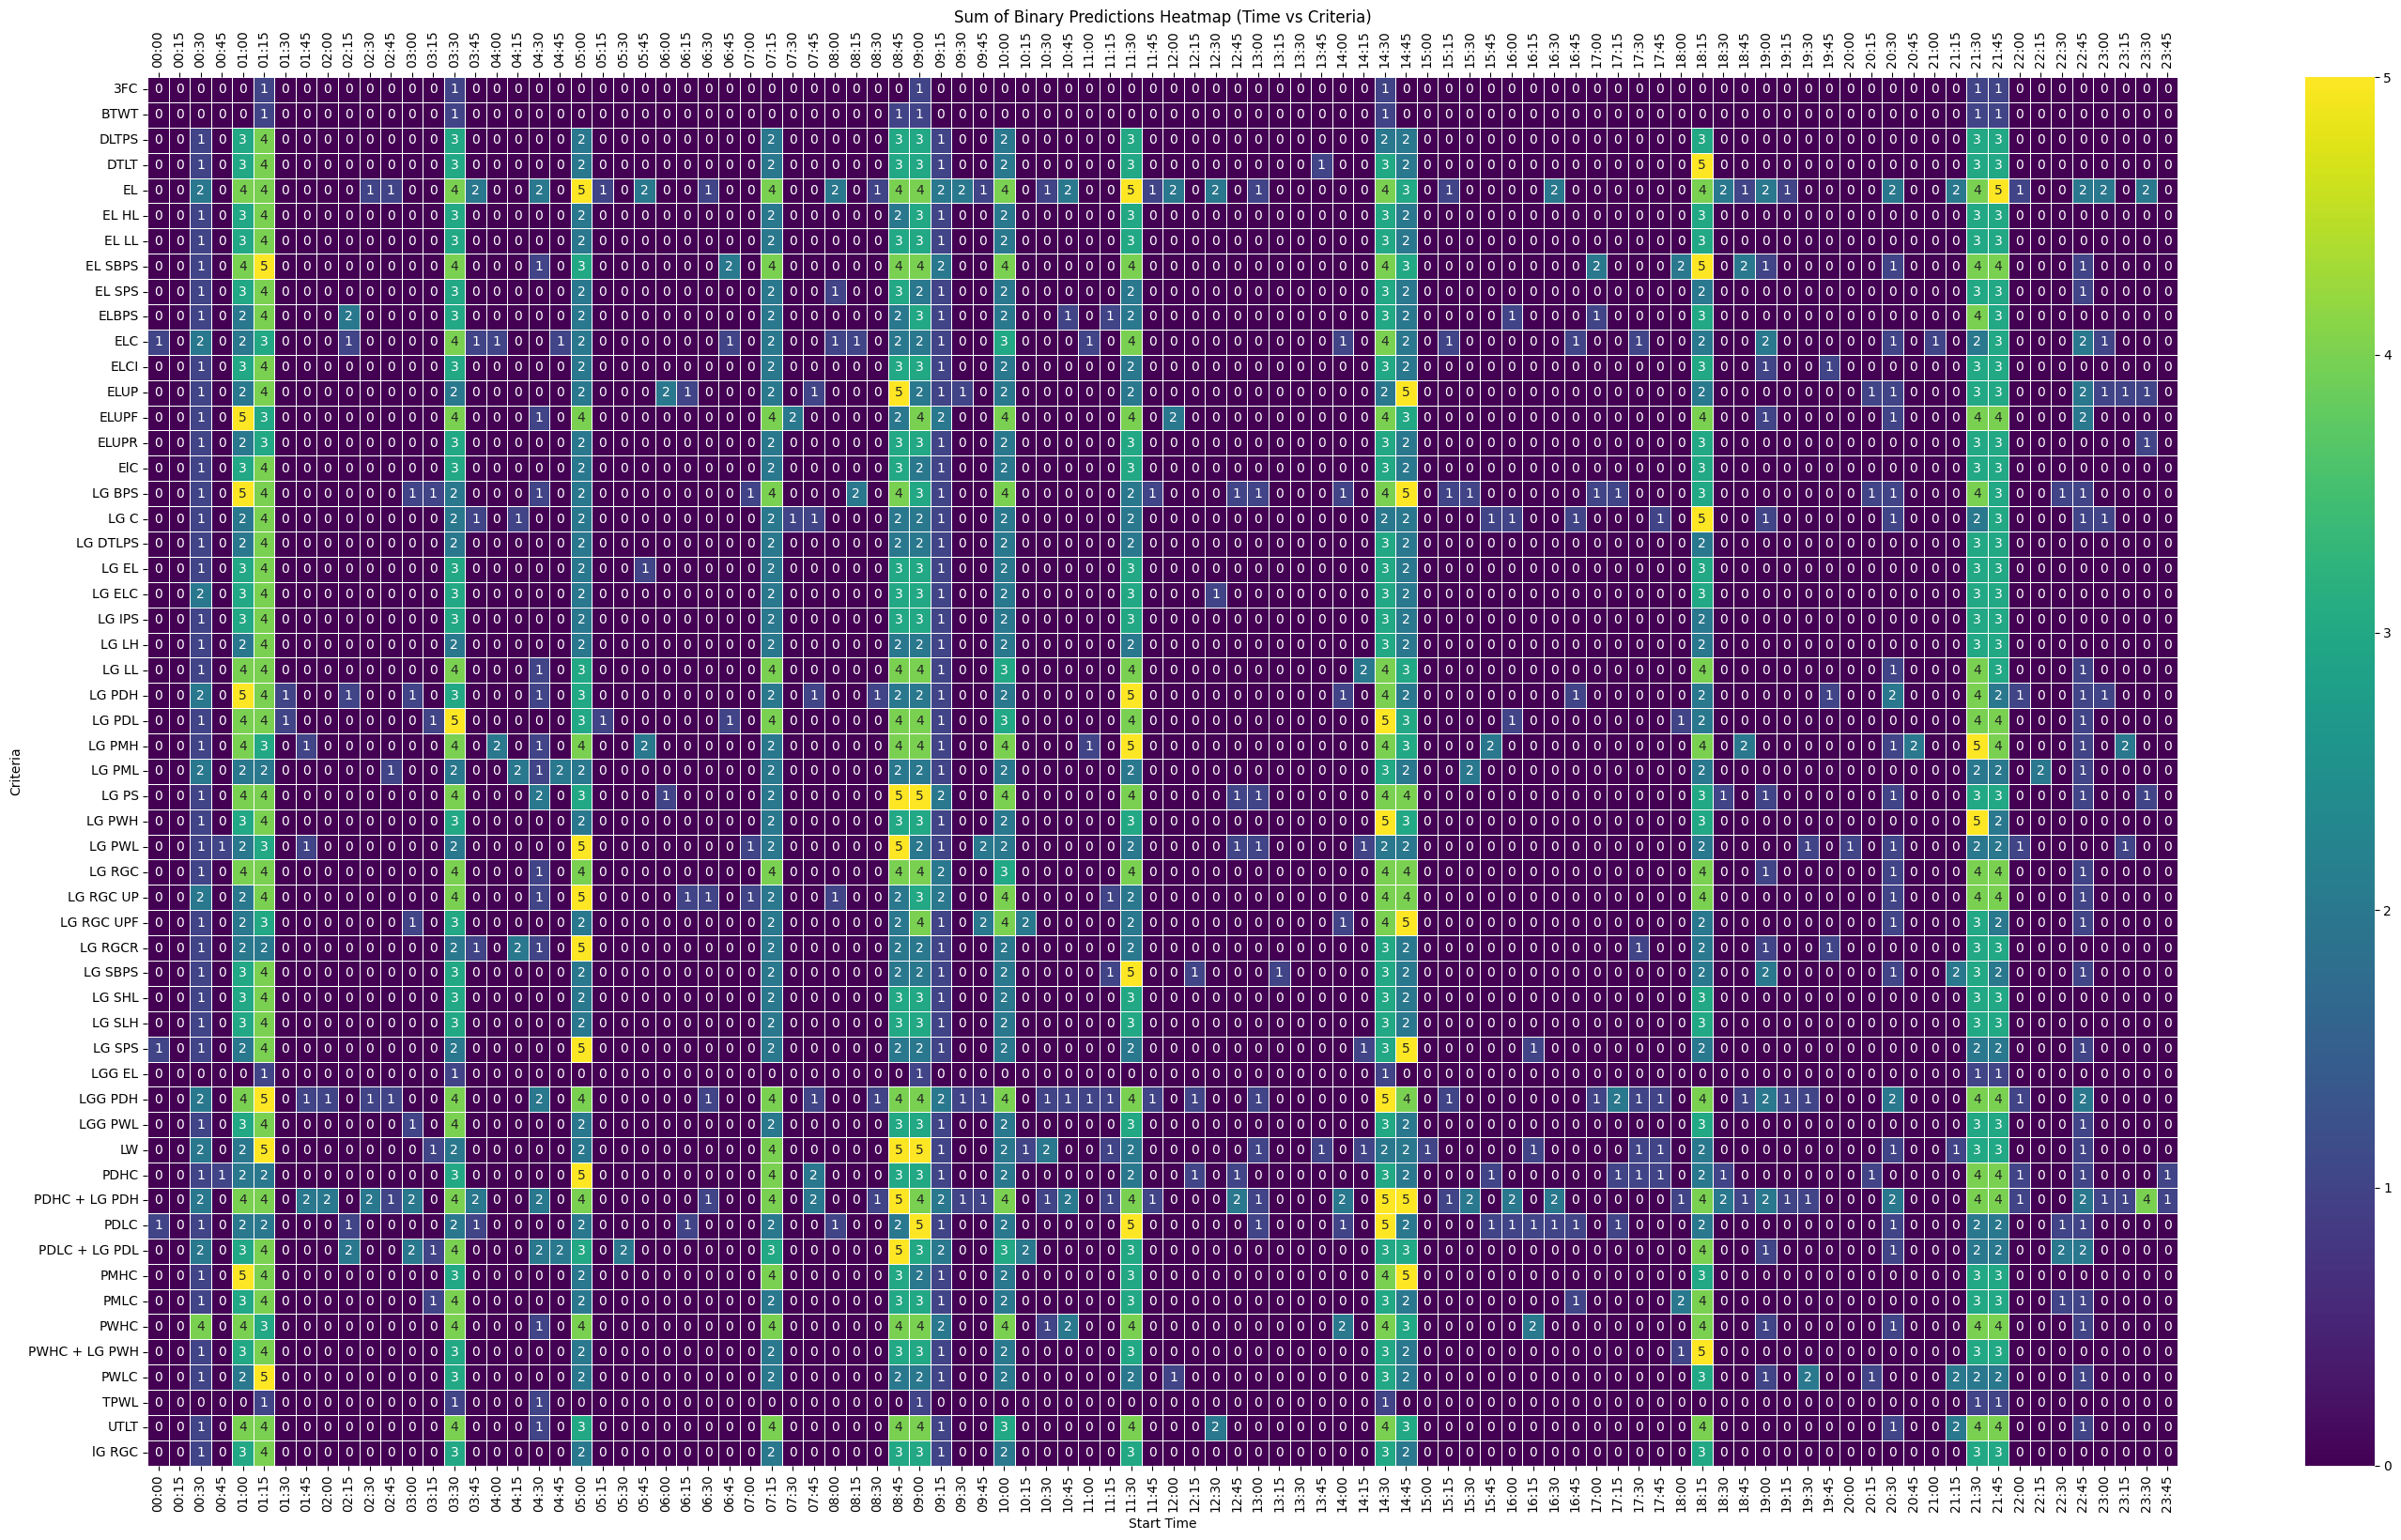

In [50]:
def plot_prediction_heatmap(predictions_df):
    """
    Generates a heatmap of the sum of binary predictions.

    Args:
        predictions_df (pd.DataFrame): DataFrame containing 'Time', 'Criteria',
                                      and 'Binary_Prediction_Sum' columns.
    """
    if predictions_df.empty:
        print("No prediction data to plot.")
        return

    # Pivot the DataFrame to create a matrix for the heatmap
    heatmap_data = predictions_df.pivot(index='Criteria', columns='Time', values='Binary_Prediction_Sum')

    # Ensure all time values from the original list are present as columns
    # This is important if some time/criteria combinations didn't appear in the data
    all_times = sorted(predictions_df['Time'].unique())
    heatmap_data = heatmap_data.reindex(columns=all_times)

    num_intervals = len(all_times)  # should be 96
    fig_width = num_intervals * 0.3
    fig_height = len(predictions_df['Criteria'].unique())*.3

    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='viridis', linewidths=.5)
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis='x', which='both', labeltop=True, top=True, bottom=True, rotation=90)
    plt.title('Sum of Binary Predictions Heatmap (Time vs Criteria)')
    plt.xlabel('Start Time')
    plt.ylabel('Criteria')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()
plot_prediction_heatmap(prediction_combinations_df)